# Fake Reviews Detection on Movie Reviews through Sentiment Analysis
## By Srivatsa

Problem Statement
##### Sentiment analysis or opinion mining is a natural language processing (NLP) technique used to determine the polarity of a given text - whether it is positive, negative, or neutral.
##### One of the main issues under sentiment analysis is the extraction of emotions from opinion reviews and identification of fake positive and fake negative reviews from them.

Importing libraries

In [1]:
import pandas as pd
import re,string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost.sklearn import XGBClassifier
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Mounting the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the Dataset

In [3]:
data = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

print(data.describe)

<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>


In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


From the above output we see that in our data we have postive and negative in out target variable

1.   positive = '1'
2.   negative = '0'



In [5]:
data.sentiment=data.sentiment.apply(lambda x: 0 if x=='negative' else 1)

data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


**Feature Engineering**
(Text Data preprocessing- Tokenization)

1.   Sentence count in each review
2.   Word count
3.   Number of unique words
4.   Number of punctuation
5.   Number of Upper case
6.   Number of stop words
7.   Average length of a word


In [6]:
#downloading the stopwords
eng_stopwords = set(stopwords.words("english"))


In [7]:
# A new column to show the Sentence count in each review
data['count_sent']=data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

In [8]:
# A new column to show the word count in each review

data['count_word']=data["review"].apply(lambda x: len(str(x).split()))

In [9]:
# word count

data['count_unique_word']=data["review"].apply(lambda x: len(set(str(x).split())))

# str(x): Converts the entry to a string.
# .split(): Splits the string into a list of words based on whitespace.
# set(...): Converts the list of words into a set, which automatically removes duplicates, retaining only unique words.
# len(...): Calculates the length (count) of the unique words in the set.


In [10]:
# letter count
data['count_letters']=data["review"].apply(lambda x: len(str(x)))
# punctuations count
data["count_punctuations"] =data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#  count words that are entirely in upper case
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# count words that start with a upper case
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# count of stopwords in a each reivew
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
# mean word length
data["mean_word_len"] = data["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [11]:
# unique words percentage
data['word_unique_percent']=data['count_unique_word']*100/data['count_word']


In [12]:
# punctuation percentage wrt words
data['punct_percent']=data['count_punctuations']*100/data['count_word']


In [13]:
# arranging the columns in our data frame
data = data[['review', 'count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent','sentiment']]

In [14]:
data.sample(2)

,review,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,sentiment
42539,I have always admired Susan Sarandon for her i...,1,153,104,852,10,6,24,70,4.575163,67.973856,6.535948,0
7794,The 3rd and in my view the best of the Blackad...,1,112,87,660,34,0,13,49,4.901786,77.678571,30.357143,1


Visualization to identify Classification aprroach

Shows histograms to observe patterns in positive and negative reviews based on word count.

---



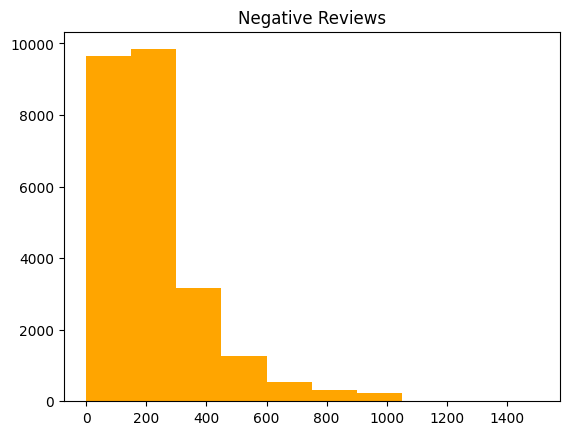

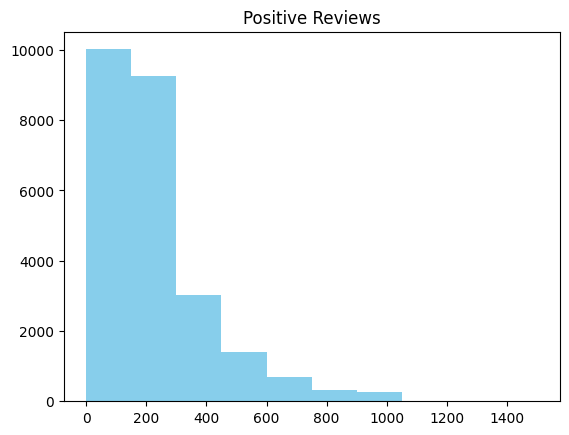

In [15]:
# visualization of wordcount
plt.hist(data[data['sentiment']==0]['count_word'],range=(0,1500),color='orange')
plt.title('Negative Reviews')
plt.show()
plt.hist(data[data['sentiment']==1]['count_word'],range=(0,1500),color='skyblue')
plt.title('Positive Reviews')
plt.show()

# Summary of all the features of the dataset

### Upon investigation, it can be inferred that there isn't a feature in the dataset that can be used to train a classification model. The classification model thus has to be built using word vectorizer and count vectorizer.

In [16]:
data.groupby(['sentiment'],as_index=False).mean()

<ipython-input-16-4f775c7a50c0>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(['sentiment'],as_index=False).mean()


,sentiment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0,1.0,229.46456,152.2662,1294.06436,53.59836,5.14632,24.72780,103.38132,4.623461,70.896372,23.447622
1,1,1.0,232.84932,152.0156,1324.79768,51.55876,4.56928,27.96804,104.31900,4.657892,70.164729,22.077985


# Preprocessing reviews

In this section of the notebook we preprocess the data before building the classification model. We implement the following functions to clean the data before model building.

1.   Removal of Punctuation Marks
2.   Cleaning Contractions
3.   Eliminated Stop Words
4.   Removal of HTML tags and URLs
5.   Lemmatization



In [17]:
# Removing all punctuations from review
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "don't" : "do not"}

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(review):
    return review.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Cleaning all contractions
def clean_contractions(review, mapping):
    specials = ["’", "‘", "´", "`", "_"]
    for s in specials:
        if s == "_":
          review = review.replace(s, " ")
        else:
          review = review.replace(s, "'")
    review = ' '.join([mapping[t] if t in mapping else t for t in review.split(" ")])
    return review

# Remove the stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(review):
    return " ".join([word for word in str(review).split() if word not in STOPWORDS])

# Remove break tags
def word_replace(review):
    return review.replace('<br />','')



# STEMMING- it is a process of stripping the affixes and suffixes and getting the stem of the word

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(review):
    return " ".join([stemmer.stem(word) for word in review.split()])


# LEMMATIZATION - it is a process of grouping words together based on their meaning

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(review):
    return " ".join([lemmatizer.lemmatize(word) for word in review.split()])

# Removing links and urls from the reviews
def remove_urls(review):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', review)

# Remove html tags
def remove_html(review):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', review)

# Collab all functions to a single function name it preprocess
def preprocess(review):
    review=clean_contractions(review,mapping)
    review=review.lower()
    review=word_replace(review)
    review=remove_urls(review)
    review=remove_html(review)
    review=remove_stopwords(review)
    review=remove_punctuation(review)
    # review=stem_words(review)
    review=lemmatize_words(review)

    return review

In [18]:
data["review_p"] = data["review"].apply(lambda review: preprocess(review))

In [19]:
print(data[['review', 'review_p']])

                                                  review  \
0      One of the other reviewers has mentioned that ...   
1      A wonderful little production. <br /><br />The...   
2      I thought this was a wonderful way to spend ti...   
3      Basically there's a family where a little boy ...   
4      Petter Mattei's "Love in the Time of Money" is...   
...                                                  ...   
49995  I thought this movie did a down right good job...   
49996  Bad plot, bad dialogue, bad acting, idiotic di...   
49997  I am a Catholic taught in parochial elementary...   
49998  I'm going to have to disagree with the previou...   
49999  No one expects the Star Trek movies to be high...   

                                                review_p  
0      one reviewer mentioned watching 1 oz episode h...  
1      wonderful little production filming technique ...  
2      thought wonderful way spend time hot summer we...  
3      basically family little boy jake thi

In [20]:
# EVALUATION METRICS FUNCTION
def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

In [21]:
X=data[['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']]
y=data['sentiment']

In [22]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


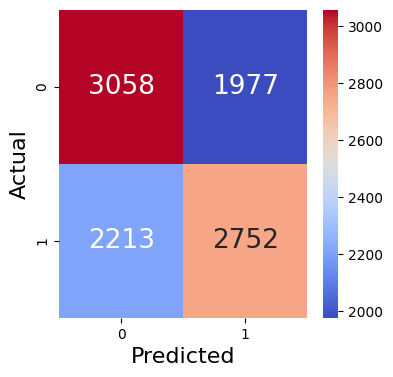


Accuracy:  0.58

F1 Score:  0.57

Report:               precision    recall  f1-score   support

           0       0.58      0.61      0.59      5035
           1       0.58      0.55      0.57      4965

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



In [23]:
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(X_train, y_train)
metrics(classifier,X_test,y_test)

#### As expected, the classification model performed poorly and gave an accuracy of just 58%.  so lets proceed to use TextBlob which is a Lexicon-based sentiment analyzer, for training the classification model.

### N-gram Analysis

#### In this section we tried to identify the most suitable value of N in ngram_range parameter of the word and count vectorizer present in sklearn library.

In [24]:
reviews = ' '.join(data['review_p'])
string = reviews.split(" ")

In [25]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:7]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (10,5))
    return sns.barplot(x='count',y='word', data=n_gram_df)

       word  count
0  (movie,)  98938
1   (film,)  89754
2    (one,)  52648
3   (like,)  39780
4  (would,)  30291


<Axes: xlabel='count', ylabel='word'>

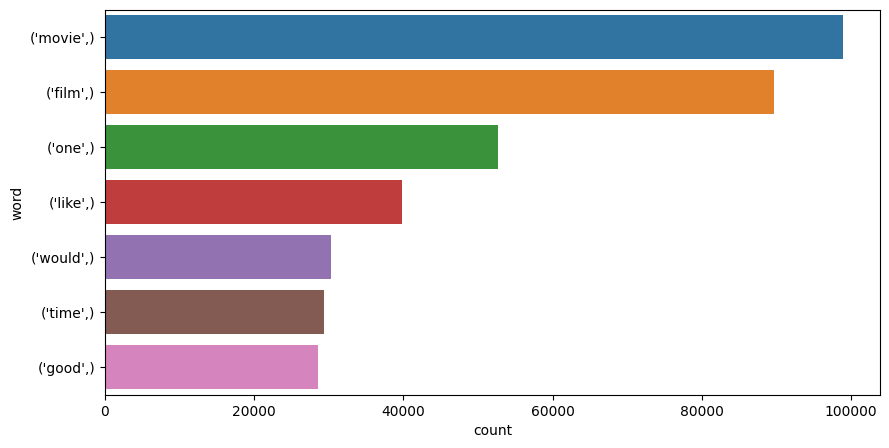

In [26]:
# N-gram  N=1
draw_n_gram(string,1)

                word  count
0       (look, like)   2874
1       (ever, seen)   2534
2  (special, effect)   2198
3      (movie, ever)   1937
4  (main, character)   1875


<Axes: xlabel='count', ylabel='word'>

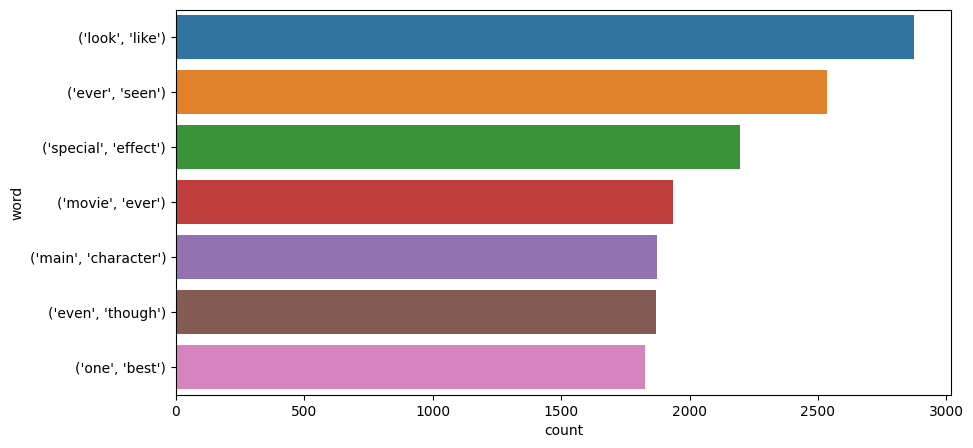

In [27]:
# N-gram  N=2
draw_n_gram(string,2)

                   word  count
0   (movie, ever, seen)    828
1  (worst, movie, ever)    731
2    (film, ever, seen)    413
3   (worst, film, ever)    344
4   (movie, ever, made)    337


<Axes: xlabel='count', ylabel='word'>

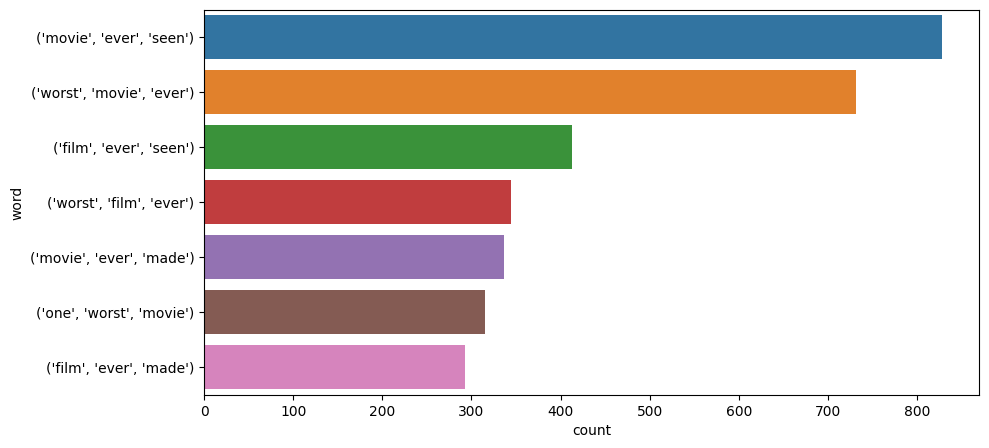

In [28]:
# N-gram  N=3
draw_n_gram(string,3)


#### Upon investigation, Trigram seemed the most suitable appropriate for our usecase and we chose ngram_range = (1,3) for our vectorizers.

In [ ]:
# FREQUENCY BASED VECTORIZATION

# This involves the mapping of a word using a dictionary to a vector.


In [29]:
X_train, X_test, y_train, y_test = train_test_split(data['review_p'], data['sentiment'], test_size=0.2,random_state=0)

In [30]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(40000,), (10000,), (40000,), (10000,)]

In [31]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=10000
)

word_vectorizer.fit(data['review_p'])

tfidf_train = word_vectorizer.transform(X_train)
tfidf_test = word_vectorizer.transform(X_test)

In [32]:
print('Shape of tfidf_train:',tfidf_train.shape)
print('Shape of tfidf_test:',tfidf_test.shape)

Shape of tfidf_train: (40000, 10000)
Shape of tfidf_test: (10000, 10000)


In [33]:
cv=CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}',ngram_range=(1,3),max_features=10000)
cv.fit(data['review_p'])
cv_train=cv.transform(X_train)
cv_test=cv.transform(X_test)

In [34]:
print('Shape of cv_train:',cv_train.shape)
print('Shape of cv_test:',cv_test.shape)

Shape of cv_train: (40000, 10000)
Shape of cv_test: (10000, 10000)


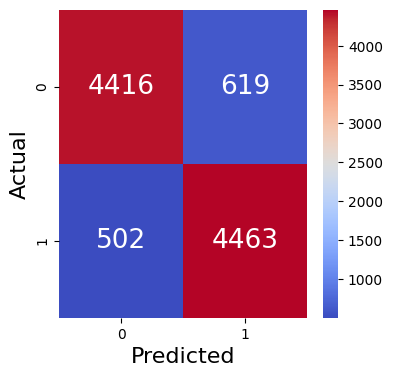


Accuracy:  0.89

F1 Score:  0.89

Report:               precision    recall  f1-score   support

           0       0.90      0.88      0.89      5035
           1       0.88      0.90      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [35]:
# Logistic Regression with TF-IDF
classifier = LogisticRegression(penalty='l2',C=0.5, solver = 'newton-cg')
classifier.fit(tfidf_train, y_train)
metrics(classifier,tfidf_test,y_test)

In [36]:
from sklearn.naive_bayes import MultinomialNB

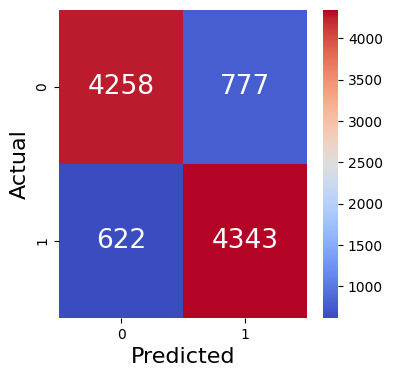


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.85      0.86      5035
           1       0.85      0.87      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [37]:
#Naive Bayes with TF-IDF
model= MultinomialNB()

model.fit(tfidf_train, y_train)
metrics(model,tfidf_test,y_test)

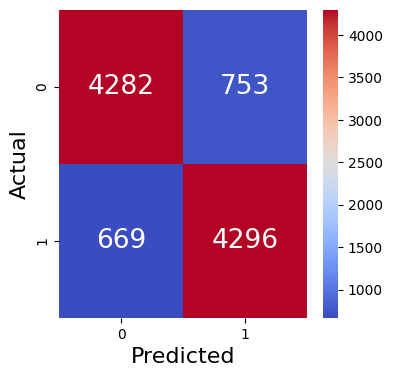


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.86      0.85      0.86      5035
           1       0.85      0.87      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [38]:
#Naive Bayes with Count Vectorizer
modela= MultinomialNB()

modela.fit(cv_train, y_train)
metrics(modela,cv_test,y_test)

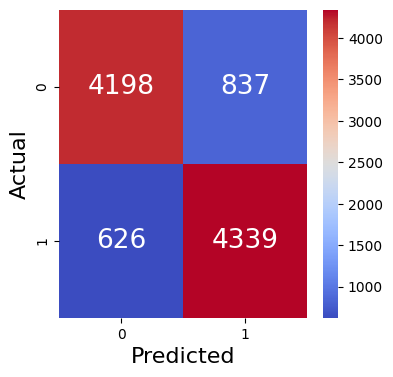


Accuracy:  0.85

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.83      0.85      5035
           1       0.84      0.87      0.86      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [39]:
#Default XGBoost Model with TF_IDF
model = XGBClassifier()
model.fit(tfidf_train, y_train)

metrics(model,tfidf_test,y_test)

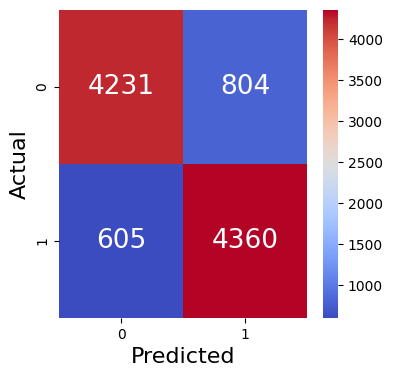


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.84      0.86      5035
           1       0.84      0.88      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [40]:
#Default XGBoost Model with Count Vectorizer
modelcv = XGBClassifier()
modelcv.fit(cv_train, y_train)

metrics(modelcv,cv_test,y_test)


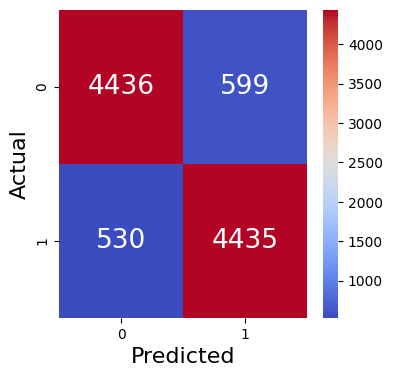


Accuracy:  0.89

F1 Score:  0.89

Report:               precision    recall  f1-score   support

           0       0.89      0.88      0.89      5035
           1       0.88      0.89      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [41]:
#SVM with TF-IDF
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(penalty='l2')
linear_svc.fit(tfidf_train, y_train)
metrics(linear_svc,tfidf_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


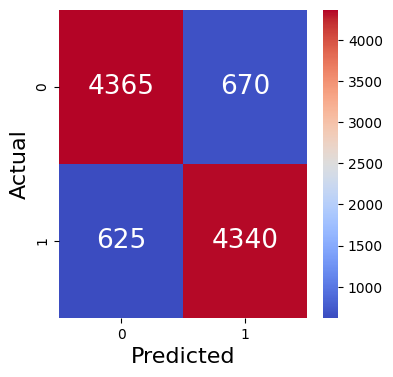


Accuracy:  0.87

F1 Score:  0.87

Report:               precision    recall  f1-score   support

           0       0.87      0.87      0.87      5035
           1       0.87      0.87      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [42]:
#SVM with Count Vectorizer
linear_svc1 = LinearSVC(C=0.1, random_state=20000)
linear_svc1.fit(cv_train, y_train)

metrics(linear_svc1,cv_test,y_test)

### Logistic Regression using word vectorizer and SVM using word vectorizer gave the largest accuracy of 89% for the given dataset.